## MODELO A: Detección de Toxicidad en Textos

Esta primera tarea consistirá en desarrollar un clasificador para evaluar si un comentario es **Tóxico (1)** o **Neutral (0)**.
Para ello desarrollaremos diferentes modelos y evaluaremos su rendimiento:

En primer lugar, desarrollaremos dos modelos que utilizan algoritmos clásicos de Machine Learning:
- Uso de BagOfWords para contar la frecuencia de las palabras y clasificación con Logistic Regression.
- Uso de TF-IDF para contar la importancia de las palabras y clasificación con Support Vector Machine.

En segundo lugar, implementaremos una CNN, en la que probaremos 4 escenarios de inicialización de embeddings:
- A. CNN From Scratch donde la capa de embeddings se inicializa con valores aleatorios (aprendizaje de vocabulario y clasificación de manera simultánea).
- B. CNN + Word2Vec Frozen donde cargamos los pesos de un Word2Vec entrenado con los propios datos y se congelan.
- C. CNN + Word2Vec Fine-Tuned donde cargamos los pesos de un Word2Vec entrenado con los propios datos pero se ajustan durante el entrenamiento.
- D. CNN + GloVe Fine-Tuned donde se inicializa la capa de embeddings con los vectores de un GloVe pre-entrenado (con millones de datos) y sus pesos se fine-tunean.

Finalmente, usaremos embeddings contextuales:
 - E. Fine-Tuning de BERT Multilingual (bert-base-multilingual-cased) ajustando los pesos del modelo preentrenado
 - F. Fine-Tuning de DistilBERT Uncased (distilbert-base-uncased) ajustando los pesos del modelo preentrenado


## 1. Carga y Preprocesamiento de Datos

Cargaremos los siguientes conjuntos de datos:
* **English Multilingual Toxicity** 
* **Paradetox** 
* **Toxic Spans** 

Convertiremos todos los textos a tokens y concatenaremos los conjuntos unificando los formatos.

In [1]:
# En primer lugar, procesaremos todos los datasets que usaremos.
# Cargaremos cada conjunto y convertimos las cadenas de texto en listas de Python. 

# Uniremos los 4 conjuntos en uno solo con la siguiente estructura (text_tokens, text_str, toxic).

import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split

# 1. DATASET PRINCIPAL (English Multilingual Toxicity)
df_1 = pd.read_csv("datos/english_multilingual_toxicity_preprocessed_non_lemmatized.csv")
df_1['text_tokens'] = df_1['text_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_1['text_str'] = df_1['text_tokens'].apply(lambda x: " ".join(x))
df_final_1 = df_1[['text_tokens', 'text_str', 'toxic']].copy()

# 2. DATASET PARADETOX - PARTE TÓXICA
#Aquí cargamos solo la parte tóxica, por ello asignamos la etiqueta 1 directamente
df_para_raw = pd.read_csv("datos/english_paradetox_preprocessed_non_lemmatized.csv")
df_final_2 = pd.DataFrame()
df_final_2['text_tokens'] = df_para_raw['toxic_sentence_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_2['text_str'] = df_final_2['text_tokens'].apply(lambda x: " ".join(x))
df_final_2['toxic'] = 1  

# 3. DATASET PARADETOX - PARTE NEUTRAL
#Aquí cargamos solo la parte neutral, por ello asignamos la etiqueta 0 directamente
df_final_3 = pd.DataFrame()
df_final_3['text_tokens'] = df_para_raw['neutral_sentence_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_3['text_str'] = df_final_3['text_tokens'].apply(lambda x: " ".join(x))
df_final_3['toxic'] = 0  

# 4. DATASET TOXIC SPANS (Solo Tóxicos)
df_spans_raw = pd.read_csv("datos/english_toxic_spans_preprocessed_non_lemmatized.csv")
df_final_4 = pd.DataFrame()
df_final_4['text_tokens'] = df_spans_raw['Sentence_tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_final_4['text_str'] = df_final_4['text_tokens'].apply(lambda x: " ".join(x))
df_final_4['toxic'] = 1  

# Uniremos los 4 en una lista y los concatenaremos en 'df_augmentado'
lista_dfs = [df_final_1, df_final_2, df_final_3, df_final_4]
df_augmentado = pd.concat(lista_dfs, ignore_index=True)

# Se eliminan los duplicados basándonos en la columna 'text_str'
df_augmentado.drop_duplicates(subset='text_str', inplace=True)

# Y se mezcla aleatoriamente el DataFrame resultante (se barajan el 100% de las filas y se reinician los índices)
df_augmentado = df_augmentado.sample(frac=1, random_state=1234).reset_index(drop=True)

# Imprimimos la estructura
print(f"Número de filas finales: {len(df_augmentado)}") # Número final de filas del conjunto
print("Distribución de los valores en la columna 'toxic':") 
print(df_augmentado['toxic'].value_counts()) # Distribución de clases (tóxico/no tóxico) en la columna 'toxic'

Número de filas finales: 6292
Distribución de los valores en la columna 'toxic':
toxic
1    3400
0    2892
Name: count, dtype: int64


### División del Dataset (Train/Validation/Test)

Separamos los datos en:
* **Entrenamiento (70%):** Para ajustar los pesos de los modelos.
* **Validación (15%):** Para monitorear el rendimiento en cada époch.
* **Prueba (15%):** Para evaluar el rendimiento final.

La idea es que para los entrenamientos y el ajuste de hiperparámetros se usen el Train y el Validation set y finalmente con el Test set compararemos los resultados de cada uno de ellos para ver cuál es el mejor.



In [2]:
# Dividiremos en train, test y validation (70%-15%-15%).

df_temporal, test_df = train_test_split(df_augmentado, test_size=0.15, stratify=df_augmentado['toxic'], random_state=1234)
train_df, val_df = train_test_split(df_temporal, test_size=0.1765, stratify=df_temporal['toxic'], random_state=1234) # 0.1765 es aprox el 15% del total original,

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

print(f"Train shape: {train_df.shape}") # Tamaño del conjunto de entrenamiento
print(f"Test shape: {test_df.shape}") # Tamaño del conjunto de prueba
print(f"Validation shape: {val_df.shape}") # Tamaño del conjunto de validación
print(train_df.head())  # Primeras filas del conjunto de entrenamiento
print(test_df.head())  # Primeras filas del conjunto de prueba
print(val_df.head())  # Primeras filas del conjunto de validación

Train: 4404 | Val: 944 | Test: 944
Train shape: (4404, 3)
Test shape: (944, 3)
Validation shape: (944, 3)
                                            text_tokens  \
2960  [honor, pride, month, please, donate, gofundme...   
1469  [slapping, unconscious, girl, s, real, o-3, pu...   
2470  [fucking, loser, n't, cheat, wife, like, rest,...   
114   [sort, retard, faggot, goes, life, caring, mea...   
5633  [holy, shit, finished, season, good, dark, esp...   

                                               text_str  toxic  
2960  honor pride month please donate gofundme help ...      0  
1469         slapping unconscious girl s real o-3 pussy      1  
2470          fucking loser n't cheat wife like rest us      1  
114      sort retard faggot goes life caring mean words      1  
5633  holy shit finished season good dark especially...      1  
                                            text_tokens  \
5238  [people, talk, color, artists, try, capture, p...   
3947                           

## 2. Algorítmos de ML clásicos
Antes de utilizar Deep Learning, establecemos una línea base con modelos clásicos para tener una referencia de rendimiento.

* **Modelo 1 (Bag of Words + Regresión Logística):** Se basa puramente en la frecuencia de aparición de palabras. Es rápido y sencillo.
* **Modelo 2 (TF-IDF + SVM):** Pondera las palabras según su importancia. SVM busca el margen máximo de separación entre clases.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Bag of Words + Logistic Regression 

# A. Aplicamos el CountVectorizer, con un umbral mínimo de frecuencia de 2 (ignorar palabras que aparecen en menos de 2 filas), de esta forma evitamos palabras muy raras que solo aparezcan 1 vez.
# Lo aplicamos tanto al train como al validation
vectorizer_bow = CountVectorizer(min_df=2) 
X_train_bow = vectorizer_bow.fit_transform(train_df['text_str'])
X_val_bow = vectorizer_bow.transform(val_df['text_str']) 

# B. Entrenamos el modelo LogisticRegression para clasificar la toxicidad sobre el conjunto de entrenamiento (1000 iteraciones)
clf_lr = LogisticRegression(max_iter=1000, random_state=1234)
clf_lr.fit(X_train_bow, train_df['toxic'])

# C. Evaluamos el modelo en el conjunto de validación e imprimimos el informe de clasificación
y_pred_lr = clf_lr.predict(X_val_bow)
print(classification_report(val_df['toxic'], y_pred_lr))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       434
           1       0.94      0.91      0.93       510

    accuracy                           0.92       944
   macro avg       0.92      0.92      0.92       944
weighted avg       0.92      0.92      0.92       944



In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# TF-IDF + SVM 

# A. Aplicamos el TfidfVectorizer, con un umbral mínimo de frecuencia de 2 (ignorar palabras que aparecen en menos de 2 filas)
# Lo aplicamos tanto al train como al validation
vectorizer_tfidf = TfidfVectorizer(min_df=2)
X_train_tfidf = vectorizer_tfidf.fit_transform(train_df['text_str'])
X_val_tfidf = vectorizer_tfidf.transform(val_df['text_str'])

# B. Entrenamos el modelo para clasificar la toxicidad sobre el conjunto de entrenamiento 
# Usamos un kernel lineal para SVM, por la alta dimensionalidad de los datos es mucho más apropiado que un kernel RBF u otro no lineal
clf_svm = SVC(kernel='linear', random_state=1234)
clf_svm.fit(X_train_tfidf, train_df['toxic'])

# C. Evaluamos el modelo en el conjunto de validación e imprimimos el informe de clasificación
y_pred_svm = clf_svm.predict(X_val_tfidf)
print(classification_report(val_df['toxic'], y_pred_svm))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       434
           1       0.93      0.91      0.92       510

    accuracy                           0.92       944
   macro avg       0.92      0.92      0.92       944
weighted avg       0.92      0.92      0.92       944



Evaluaremos el modelo usando el conjunto de test.

In [5]:
from sklearn.metrics import accuracy_score

print(f"--- EVALUACIÓN EN CONJUNTO DE TEST ({len(test_df)} muestras) ---\n")

# ==========================================
# EVALUACIÓN MODELO 1: BoW + LR
# ==========================================

# 1. Transformar el texto de TEST usando el vocabulario aprendido (Bag of Words)
# IMPORTANTE: Usamos .transform(), NUNCA .fit() en test
X_test_bow = vectorizer_bow.transform(test_df['text_str'])

# 2. Generar predicciones nuevas para el test
y_pred_lr_test = clf_lr.predict(X_test_bow)

# 3. Comparar predicción vs realidad
aciertos_lr = accuracy_score(test_df['toxic'], y_pred_lr_test)
num_aciertos_lr = (y_pred_lr_test == test_df['toxic']).sum()

print(f"Modelo 1 (BoW + LR) acertó: {num_aciertos_lr} de {len(test_df)} ({aciertos_lr:.2%})")


# ==========================================
# EVALUACIÓN MODELO 2: TF-IDF + SVM 
# ==========================================

# 1. Transformar el texto de TEST usando el vocabulario aprendido (TF-IDF)
X_test_tfidf = vectorizer_tfidf.transform(test_df['text_str'])

# 2. Generar predicciones nuevas para el test
y_pred_svm_test = clf_svm.predict(X_test_tfidf)

# 3. Comparar predicción vs realidad
aciertos_svm = accuracy_score(test_df['toxic'], y_pred_svm_test)
num_aciertos_svm = (y_pred_svm_test == test_df['toxic']).sum()

print(f"Modelo 2 (TF-IDF + SVM) acertó: {num_aciertos_svm} de {len(test_df)} ({aciertos_svm:.2%})")

--- EVALUACIÓN EN CONJUNTO DE TEST (944 muestras) ---

Modelo 1 (BoW + LR) acertó: 845 de 944 (89.51%)
Modelo 2 (TF-IDF + SVM) acertó: 845 de 944 (89.51%)


## 3. Preparación para Deep Learning
Las redes neuronales requieren entradas de tamaño fijo. Analizamos la distribución de la longitud de las frases para decidir el tamaño de corte (`max_len`).
Buscamos un valor que cubra la gran mayoría de los casos sin introducir demasiado relleno (padding) innecesario.

In [6]:
longitudes = train_df['text_tokens'].apply(len)

# Imprimiremos los datos básicos de las longitudes
print(f"Frase más larga: {longitudes.max()} palabras")
print(f"Longitud media: {longitudes.mean():.2f} palabras")
print(f"El 95% de las frases miden menos de: {longitudes.quantile(0.95)} palabras")
print(f"El 99% de las frases miden menos de: {longitudes.quantile(0.99)} palabras")

#Verificaremos que 25 es una buena longitud para el padding/truncamiento (engloba más del 99.9% de las frases)
porcentaje_englobado = ((longitudes <= 25).sum() / len(longitudes)) * 100
print(f"Porcentaje de frases con 25 palabras o menos: {porcentaje_englobado:.2f}%")

Frase más larga: 31 palabras
Longitud media: 7.24 palabras
El 95% de las frases miden menos de: 13.0 palabras
El 99% de las frases miden menos de: 16.0 palabras
Porcentaje de frases con 25 palabras o menos: 99.93%


Al final, hemos elegido (`max_len` = 25) puesto que contiene la mayor parte de las frases ( > 99.9%)

### Creación del Vocabulario y DataLoaders
Transformamos el texto en secuencias numéricas:
1. **Vocabulario:** Mapeamos cada palabra única a un índice entero. Usamos tokens especiales:
   * `<PAD>` (0): Para rellenar frases cortas.
   * `<UNK>` (1): Para palabras que no existen en el vocabulario de entrenamiento.
2. **Dataset Pytorch:** Clase que convierte las frases en tensores y aplica el padding o truncmiento.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# Se construye el vocabulario a partir del conjunto de entrenamiento
# Conteo de palabras 
word_counts = Counter()
for tokens in train_df['text_tokens']:
    word_counts.update(tokens)

# <PAD>=0, <UNK>=1
vocab = {"<PAD>": 0, "<UNK>": 1} # <PAD> para padding (relleno), <UNK> para palabras desconocidas
next_idx = 2
min_freq = 2 # Ignorar palabras que aparecen solo 1 vez para reducir ruido

# Solo se incluyen en el vocabulario las palabras que aparecen al menos 2 veces
for word, count in word_counts.items():
    if count >= min_freq:
        vocab[word] = next_idx
        next_idx += 1
print(f"Tamaño del vocabulario: {len(vocab)}")

# Se define la clase Dataset personalizada
class ToxicityDataset(Dataset):
    def __init__(self, dataframe, vocab, max_len=25):
        self.data = dataframe.reset_index(drop=True)    # Se almacenarán los datos del DataFrame
        self.vocab = vocab  # Se almacenará el vocabulario 
        self.max_len = max_len  # Longitud máxima para padding/truncamiento (25)
        
    def __len__(self):
        return len(self.data)   # Usado por DataLoader para saber el tamaño del dataset
    
    def __getitem__(self, idx): # Definir transformaciones para cada fila
        tokens = self.data.loc[idx, 'text_tokens']
        label = self.data.loc[idx, 'toxic']
        
        indices = [self.vocab.get(t, self.vocab["<UNK>"]) for t in tokens] # Asigna índices, usa <UNK> si la palabra no está en el vocabulario
        if len(indices) < self.max_len: # Padding, rellena con <PAD> si es más corto que max_len hasta alcanzar max_len
            indices += [self.vocab["<PAD>"]] * (self.max_len - len(indices))
        else:   # Truncating, truncar si es más largo que max_len
            indices = indices[:self.max_len]
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Crear Datasets y DataLoaders
train_dataset = ToxicityDataset(train_df, vocab)
val_dataset = ToxicityDataset(val_df, vocab)
test_dataset = ToxicityDataset(test_df, vocab)

# Hemos puesto shuffle=True para mezclar los datos en cada época y 128 de batch_size para acelerar el entrenamiento, con ese valor el modelo converge bien.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Tamaño del vocabulario: 3111


## 4. Arquitectura de la Red Neuronal (CNN 1D)

* **Capa Embedding:** Convierte índices enteros en vectores densos.
* **Filtros Convolucionales:** Ventanas de tamaño 3, 4 y 5. Esto permite a la red detectar patrones como trigramas (3 palabras seguidas) o secuencias de 5 palabras que denotan toxicidad.
* **Max Pooling:** Extrae la característica más relevante de cada mapa de características.
* **Salida:** Una neurona con activación `Sigmoid` (probabilidad entre 0 y 1).

In [ ]:
import torch.nn as nn
import torch.optim as optim
import copy

#Definimos la red neuronal CNN
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, pretrained_weights=None, freeze_embeddings=False):
        super(CNNClassifier, self).__init__()
        
        # Capa de Embedding
        if pretrained_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)
            
        # Capas Convolucionales (detectan patrones de 3, 4 y 5 palabras), de esta forma no solo se consideran palabras individuales sino también combinaciones de 3, 4 y 5 palabras
        # El número de filtros y canales se ha ajustado para equilibrar precisión y eficiencia, hemos probado con más pero el modelo memorizaba frases completas que conllevaban al overfitting
        self.conv1 = nn.Conv1d(embed_dim, 100, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embed_dim, 100, kernel_size=4, padding=2)
        self.conv3 = nn.Conv1d(embed_dim, 100, kernel_size=5, padding=2)
        
        self.fc = nn.Linear(300, 1) # 3 filtros * 100 canales
        self.dropout = nn.Dropout(0.5)  # Dropout para evitar overfitting, 0.5 es el balance óptimo entre retener información y evitar sobreajuste
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_emb = self.embedding(x).permute(0, 2, 1) 
        
        # Aplicar Convolución + ReLU + Max Pooling, permite detección patrones más relevantes para la clasificación, independientemente de dónde se encuentren en la frase
        # La dimensión 2 representa la longitud de la frase, es la dimensión que queremos reducir
        c1 = torch.max(torch.relu(self.conv1(x_emb)), dim=2)[0]
        c2 = torch.max(torch.relu(self.conv2(x_emb)), dim=2)[0]
        c3 = torch.max(torch.relu(self.conv3(x_emb)), dim=2)[0]
        
        # Concatenar características
        out = torch.cat((c1, c2, c3), dim=1)
        out = self.dropout(out)
        return self.sigmoid(self.fc(out)).squeeze()

# Función para entrenar y evaluar el modelo. En cada época se entrena y luego se evalúa en el conjunto de prueba. Finalmente, se implementa Early Stopping para evitar overfitting.
def train_evaluate(model, train_loader, val_loader, epochs=20, lr=0.001, patience=3):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Variables para Early Stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f"Iniciando entrenamiento por {epochs} épocas con Early Stopping (paciencia={patience})...")

    for epoch in range(epochs):
        # ENTRENAMIENTO
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
            
        # EVALUACIÓN (Validación)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                # Calculamos loss de validación para decidir si parar
                v_loss = criterion(y_pred, y_batch)
                val_loss += v_loss.item()
                
                predicted = (y_pred > 0.5).float()
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        acc = correct / total
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}")
        
        # LOGICA DE EARLY STOPPING
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0 # Mejoramos, reseteamos contador
        else:
            patience_counter += 1
            print(f"   > No mejora. Paciencia: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print("   > DETENIENDO ENTRENAMIENTO (Early Stopping triggered).")
                break
    
    # Restauramos el mejor modelo encontrado
    print(f"Restaurando el mejor modelo con Val Loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_wts)

In [9]:
from gensim.models import Word2Vec
import numpy as np

# Entrenamos el modelo Word2Vec con los datos de entrenamiento por 10 epochs
w2v_model = Word2Vec(
    sentences=train_df['text_tokens'], # Frases
    vector_size=200,                   # El tamaño del vector (embed_dim), balance entre precisión y eficiencia dado nuestro conjunto de datos de unas 6000 frases
    window=5,                          # Mira 5 palabras a los lados, para análisis de frases cortas (como lo son las de las redes sociales) es el estándar, la mayor parte de las frases rondan las 7 palabras
    min_count=2,                       # Ignora palabras que solo salgan 1 vez
    workers=4,                         # Número de hilos para entrenamiento paralelo
    epochs=10               
)

# Creamos la "Matriz de Pesos" para pasársela a la CNN
def create_embedding_matrix(vocab, w2v_model, embed_dim=200):
    vocab_size = len(vocab)
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embed_dim))
    
    hits = 0
    misses = 0
    
    for word, idx in vocab.items():
        if idx < 2: continue 
        if word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
            hits += 1
        else:
            misses += 1
            
    print(f"Embeddings cargados: {hits} palabras encontradas. {misses} no encontradas.")
    return torch.FloatTensor(embedding_matrix)

# Creamos la "Matriz de Pesos" para pasársela a la CNN
w2v_weights = create_embedding_matrix(vocab, w2v_model, embed_dim=200)

Embeddings cargados: 3109 palabras encontradas. 0 no encontradas.


## 5. Experimentos y Entrenamiento
Evaluamos las tres estrategias de inicialización para la CNN con el conjunto de Validation:

1. **From Scratch:** Embeddings inicializados aleatoriamente. La red aprende vocabulario y clasificación simultáneamente.
2. **W2V Frozen:** Usamos los pesos de Word2Vec y los congelamos. La red no puede modificar los embeddings, solo aprende a combinarlos.
3. **W2V Fine-Tuned:** Usamos Word2Vec como punto de partida, pero permitimos que la red ajuste (fine-tune) los embeddings durante el entrenamiento para optimizarlos para la tarea de toxicidad.

In [10]:
# PREPARACIÓN DE EMBEDDINGS
embed_dim = 200

# A: CNN FROM SCRATCH
model_scratch = CNNClassifier(len(vocab), embed_dim, pretrained_weights=None)
train_evaluate(model_scratch, train_loader, val_loader)

# B: CNN W2V FROZEN
model_frozen = CNNClassifier(len(vocab), embed_dim, pretrained_weights=w2v_weights, freeze_embeddings=True)
train_evaluate(model_frozen, train_loader, val_loader)

# C: CNN W2V FINE-TUNED
model_finetuned = CNNClassifier(len(vocab), embed_dim, pretrained_weights=w2v_weights, freeze_embeddings=False)
train_evaluate(model_finetuned, train_loader, val_loader)

Epoch 1/5 | Loss: 0.5343 | Acc Val: 0.7956
Epoch 2/5 | Loss: 0.3030 | Acc Val: 0.8602
Epoch 3/5 | Loss: 0.1896 | Acc Val: 0.8792
Epoch 4/5 | Loss: 0.1164 | Acc Val: 0.8400
Epoch 5/5 | Loss: 0.0731 | Acc Val: 0.8803
Epoch 1/5 | Loss: 0.7000 | Acc Val: 0.5985
Epoch 2/5 | Loss: 0.6862 | Acc Val: 0.5922
Epoch 3/5 | Loss: 0.6789 | Acc Val: 0.6165
Epoch 4/5 | Loss: 0.6754 | Acc Val: 0.6038
Epoch 5/5 | Loss: 0.6718 | Acc Val: 0.5911
Epoch 1/5 | Loss: 0.6911 | Acc Val: 0.6271
Epoch 2/5 | Loss: 0.5043 | Acc Val: 0.8242
Epoch 3/5 | Loss: 0.2281 | Acc Val: 0.9057
Epoch 4/5 | Loss: 0.1135 | Acc Val: 0.9227
Epoch 5/5 | Loss: 0.0613 | Acc Val: 0.9248


In [11]:
# Creamos una función para clasificar frases nuevas usando el modelo CNN fine-tuned
def clasificar_frase_cnn(frase, model, vocab, max_len=25):
    model.eval() 
    tokens = frase.lower().split() # Tokenizamos la frase (simple split por espacios)
    
    indices = [vocab.get(t, vocab["<UNK>"]) for t in tokens]    # Asigna índices, usa <UNK> si la palabra no está en el vocabulario
    if len(indices) < max_len:
        indices += [vocab["<PAD>"]] * (max_len - len(indices))  # Padding para que todas las frases tengan la misma longitud (25)
    else:
        indices = indices[:max_len]
        
    tensor_input = torch.tensor(indices, dtype=torch.long).unsqueeze(0)
    
    with torch.no_grad():
        probabilidad = model(tensor_input).item()   # Obtener la probabilidad de toxicidad
    etiqueta = 1 if probabilidad > 0.5 else 0   # Asignar etiqueta basada en un umbral de 0.5 (si probabilidad > 0.5, es tóxico, sino neutral)

    return etiqueta, probabilidad   # Se devuelve la etiqueta y la probabilidad

# EVALUACIÓN DE LA CNN EN EL CONJUNTO DE TEST (test_df) - FROM SCRATCH
model_scratch.eval() 

aciertos = 0
total_muestras = len(val_df)

for texto, etiqueta_real in zip(test_df['text_str'], test_df['toxic']):
    prediccion_etiqueta, _ = clasificar_frase_cnn(texto, model_scratch, vocab)
    if prediccion_etiqueta == etiqueta_real:
        aciertos += 1

accuracy = aciertos / total_muestras
print("FROM SCRATCH RESULTS:")
print(f"Aciertos: {aciertos} de {total_muestras}")
print(f"Precisión (Accuracy): {accuracy:.2%}\n")

# EVALUACIÓN DE LA CNN EN EL CONJUNTO DE TEST (test_df) - W2V FROZEN
model_frozen.eval() 

aciertos = 0
total_muestras = len(test_df)

for texto, etiqueta_real in zip(test_df['text_str'], test_df['toxic']):
    prediccion_etiqueta, _ = clasificar_frase_cnn(texto, model_frozen, vocab)
    if prediccion_etiqueta == etiqueta_real:
        aciertos += 1

accuracy = aciertos / total_muestras
print("W2V FROZEN RESULTS:")
print(f"Aciertos: {aciertos} de {total_muestras}")
print(f"Precisión (Accuracy): {accuracy:.2%}\n")


# EVALUACIÓN DE LA CNN EN EL CONJUNTO DE TEST (val_df) - W2V FINE-TUNED
model_finetuned.eval() 

aciertos = 0
total_muestras = len(test_df)

for texto, etiqueta_real in zip(test_df['text_str'], test_df['toxic']):
    prediccion_etiqueta, _ = clasificar_frase_cnn(texto, model_finetuned, vocab)
    if prediccion_etiqueta == etiqueta_real:
        aciertos += 1

accuracy = aciertos / total_muestras
print("W2V FINE-TUNED RESULTS:")
print(f"Aciertos: {aciertos} de {total_muestras}")
print(f"Precisión (Accuracy): {accuracy:.2%}\n")

# PRUEBA CON FRASES NUEVAS - W2V FINE-TUNED
frases_nuevas = [
    "I love this beautiful sunny day",
    "You are a stupid idiot and I hate you",
    "Shut up you fool",
    "You look like you belong in a zoo.",
]
print("PRUEBA CON FRASES NUEVAS - W2V FINE-TUNED:\n")
for f in frases_nuevas:
    etiqueta, probabilidad = clasificar_frase_cnn(f, model_finetuned, vocab)
    print(f"Frase: '{f}'")
    if etiqueta == 0:
        print(f"Predicción: {etiqueta}-NEUTRAL (Probabilidad: {probabilidad:.4f})\n")
    else:
        print(f"Predicción: {etiqueta}-TÓXICA (Probabilidad: {probabilidad:.4f})\n")

FROM SCRATCH RESULTS:
Aciertos: 822 de 944
Precisión (Accuracy): 87.08%

W2V FROZEN RESULTS:
Aciertos: 611 de 944
Precisión (Accuracy): 64.72%

W2V FINE-TUNED RESULTS:
Aciertos: 857 de 944
Precisión (Accuracy): 90.78%

PRUEBA CON FRASES NUEVAS - W2V FINE-TUNED:

Frase: 'I love this beautiful sunny day'
Predicción: 0-NEUTRAL (Probabilidad: 0.0015)

Frase: 'You are a stupid idiot and I hate you'
Predicción: 1-TÓXICA (Probabilidad: 1.0000)

Frase: 'Shut up you fool'
Predicción: 1-TÓXICA (Probabilidad: 0.9985)

Frase: 'You look like you belong in a zoo.'
Predicción: 1-TÓXICA (Probabilidad: 0.5193)



## 6. Transfer Learning con GloVe
Finalmente, intentamos mejorar el modelo utilizando **GloVe (Global Vectors for Word Representation)**.
A diferencia de nuestro Word2Vec (entrenado con ~5000 frases), GloVe ha sido entrenado con millones de textos de Wikipedia y la web.

* **Estrategia:** Cargamos los vectores de 100 dimensiones.
* **Manejo de desconocidas:** Las palabras que no están en GloVe se inicializan con una distribución normal aleatoria para que la red pueda aprenderlas desde cero durante el Fine-Tuning.

In [12]:
import numpy as np
import torch
import os

# CONFIGURACIÓN
GLOVE_FILE = "glove100b.txt" 
GLOVE_DIM = 100  

# Función para crear la matriz de embeddings a partir del archivo GloVe
def create_glove_matrix(vocab, glove_path, embed_dim=100):

    embeddings_index = {}
    bad_lines = 0  # Contador para líneas corruptas
    
    # Cargar el archivo GloVe
    with open(glove_path, encoding="utf8") as f:
        for i, line in enumerate(f):
            values = line.split()
            if len(values) != embed_dim + 1:   # Línea corrupta
                bad_lines += 1
                continue
            word = values[0]
            # Extraer el vector de embedding
            try:
                coefs = np.asarray(values[1:], dtype='float32') # Convertir a array numpy
                embeddings_index[word] = coefs  # Guardar en el diccionario
            except ValueError:
                bad_lines += 1
                continue

    print(f"{len(embeddings_index)} vectores válidos.")
    print(f"Bad lines: {bad_lines} .")

    vocab_size = len(vocab)
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embed_dim))
    
    hits = 0
    misses = 0
    # Rellenar la matriz de embeddings
    for word, idx in vocab.items():
        if idx < 2: continue  # Saltar índices especiales
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector    # Rellenar la matriz
            hits += 1
        else:
            misses += 1
            
    print(f"{hits} palabras encontradas. {misses} palabras no encontradas.")
    return torch.FloatTensor(embedding_matrix)

# Usamos la función 
glove_weights = create_glove_matrix(vocab, GLOVE_FILE, embed_dim=GLOVE_DIM)
model_glove_finetuned = CNNClassifier(
    vocab_size=len(vocab), 
    embed_dim=GLOVE_DIM, 
     pretrained_weights=glove_weights, 
    freeze_embeddings=False  
)   
train_evaluate(model_glove_finetuned, train_loader, val_loader)

1287614 vectores válidos.
Bad lines: 3533 .
3059 palabras encontradas. 50 palabras no encontradas.
Epoch 1/5 | Loss: 0.3961 | Acc Val: 0.9089
Epoch 2/5 | Loss: 0.1944 | Acc Val: 0.9100
Epoch 3/5 | Loss: 0.1407 | Acc Val: 0.9290
Epoch 4/5 | Loss: 0.0990 | Acc Val: 0.9216
Epoch 5/5 | Loss: 0.0741 | Acc Val: 0.9248


In [13]:
# EVALUACIÓN DE LA CNN EN EL CONJUNTO DE TEST (test_df) - W2V FINE-TUNED
model_glove_finetuned.eval() 

aciertos = 0
total_muestras = len(test_df)

for texto, etiqueta_real in zip(test_df['text_str'], test_df['toxic']):
    prediccion_etiqueta, _ = clasificar_frase_cnn(texto, model_glove_finetuned, vocab)
    if prediccion_etiqueta == etiqueta_real:
        aciertos += 1

accuracy = aciertos / total_muestras
print("GLOVE FINE-TUNED RESULTS:")
print(f"Aciertos: {aciertos} de {total_muestras}")
print(f"Precisión (Accuracy): {accuracy:.2%}\n")

# PRUEBA CON FRASES NUEVAS - GLOVE FINE-TUNED
frases_nuevas = [
    "I love this beautiful sunny day",
    "You are a stupid idiot and I hate you",
    "Shut up you fool",
    "You look like you belong in a zoo.",
]
for f in frases_nuevas:
    etiqueta, probabilidad = clasificar_frase_cnn(f, model_glove_finetuned, vocab)
    print(f"Frase: '{f}'")
    if etiqueta == 0:
        print(f"Predicción: {etiqueta}-NEUTRAL (Probabilidad: {probabilidad:.4f})\n")
    else:
        print(f"Predicción: {etiqueta}-TÓXICA (Probabilidad: {probabilidad:.4f})\n")


GLOVE FINE-TUNED RESULTS:
Aciertos: 872 de 944
Precisión (Accuracy): 92.37%

Frase: 'I love this beautiful sunny day'
Predicción: 0-NEUTRAL (Probabilidad: 0.0072)

Frase: 'You are a stupid idiot and I hate you'
Predicción: 1-TÓXICA (Probabilidad: 1.0000)

Frase: 'Shut up you fool'
Predicción: 1-TÓXICA (Probabilidad: 0.9927)

Frase: 'You look like you belong in a zoo.'
Predicción: 0-NEUTRAL (Probabilidad: 0.4469)



## 7. Embeddings Contextuales

- bert-base-multilingual-cased
- distilbert-base-uncased


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

# Adapta los outputs del tokenizer de Hugging Face al DataLoader de PyTorch (2 elementos).
class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels


    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx].astype(np.float32)) 
        
        # Devolvemos solo INPUT_IDS y LABELS
        return item['input_ids'], item['labels'] 

    def __len__(self):
        return len(self.labels)


# Esta clase intercepta la salida del modelo de Hugging Face (SequenceClassifierOutput) y la convierte en un tensor simple, para poder pasarsela a train_evaluate.
class BertClassifierWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model

        # Adaptamos la capa final del clasificador para incluir la Sigmoid (para BCELoss)
        original_classifier = self.hf_model.classifier 
        self.hf_model.classifier = torch.nn.Sequential(
            original_classifier,
            torch.nn.Sigmoid()
        )
    def forward(self, input_ids):
        attention_mask = (input_ids != 0).long()
        output = self.hf_model(input_ids=input_ids, attention_mask=attention_mask) 
        return output.logits.squeeze()

c:\Users\js834\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
MAX_LEN = 128 
BATCH_SIZE = 32
EPOCHS = 2 # Hemos usado solo 2 epochs, por que sino se llegaba al overfit muy rapido y la prueba en el Test set salia incorrecta (seleccionaba al azar una de las dos clases)

# Función para ejecutar el entrenamiento y evaluación usando un modelo de Hugging Face con PyTorch
def execute_and_evaluate_pytorch_hf(model_name_hf, description, X_train, y_train, X_test, y_test, train_evaluate_func):
    
    # 1. Tokenización 
    tokenizer = AutoTokenizer.from_pretrained(model_name_hf)
    X_train_encoded = tokenizer(
        X_train.tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt'
    )
    X_test_encoded = tokenizer(
        X_test.tolist(), max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt'
    )
    
    # 2. Preparación de DataLoaders (2 elementos) 
    train_dataset = TextClassificationDataset(X_train_encoded, y_train)
    test_dataset = TextClassificationDataset(X_test_encoded, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # 3. Carga y Envoltura del Modelo (The Fix) 
    hf_model = AutoModelForSequenceClassification.from_pretrained(
        model_name_hf, 
        num_labels=1
    )
    model = BertClassifierWrapper(hf_model)

    # 4. ENTRENAMIENTO (Llama a tu función sin modificar) 
    print(f"Iniciando Fine-Tuning de {description} usando la función 'train_evaluate'...")
    train_evaluate_func(model, train_loader, val_loader, epochs=EPOCHS, lr=2e-6) # Con mayor lr, overfiteaba muy rapido los modelos

    # 5. EVALUACIÓN FINAL 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader: # Solo desempaquetamos 2 valores
            # La llamada a model(X_batch) ejecuta BertClassifierWrapper.forward()
            y_pred = model(X_batch) 
            
            predicted = (y_pred > 0.5).float() 
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    aciertos = correct
    total_muestras = total
    accuracy = aciertos / total_muestras
    
    print(f"\n{description} RESULTS:")
    print(f"Aciertos: {aciertos} de {total_muestras}")
    print(f"Precisión (Accuracy): {accuracy:.2%}\n")
    
    return model, accuracy

In [16]:
# Usaremos estos dos modelos de Hugging Face
MODELOS_CONTEXTUALES = {
    "BERT_Multilingual": "bert-base-multilingual-cased",
    "DistilBERT_Uncased": "distilbert-base-uncased"
}
TEXT_COLUMN = 'text_str'
LABEL_COLUMN = 'toxic'

X_train = train_df[TEXT_COLUMN]
y_train = train_df[LABEL_COLUMN]

X_test = val_df[TEXT_COLUMN]
y_test = val_df[LABEL_COLUMN]
resultados_contextuales_pt = {}

model_distilbert_uncased = None
model_bert_base_cased = None

for desc, model_hf in MODELOS_CONTEXTUALES.items():
    current_model, acc = execute_and_evaluate_pytorch_hf(
        model_hf, 
        desc, 
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        train_evaluate 
    )
    # Para guardar los modelos
    if desc == "DistilBERT_Uncased":
        model_distilbert_uncased = current_model
    else:
        model_bert_base_cased = current_model
    
    resultados_contextuales_pt[desc] = {'Accuracy': acc}

# --- RESUMEN FINAL ---
resultados_df = pd.DataFrame(resultados_contextuales_pt).T
print(resultados_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\js834\AppData\Local\Temp\ipykernel_4960\1674711031.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Iniciando Fine-Tuning de BERT_Multilingual usando la función 'train_evaluate'...
Epoch 1/2 | Loss: 0.5303 | Acc Val: 0.8676
Epoch 2/2 | Loss: 0.3035 | Acc Val: 0.9100

BERT_Multilingual RESULTS:
Aciertos: 859 de 944
Precisión (Accuracy): 91.00%



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iniciando Fine-Tuning de DistilBERT_Uncased usando la función 'train_evaluate'...
Epoch 1/2 | Loss: 0.6225 | Acc Val: 0.8623
Epoch 2/2 | Loss: 0.3342 | Acc Val: 0.9195

DistilBERT_Uncased RESULTS:
Aciertos: 868 de 944
Precisión (Accuracy): 91.95%

                    Accuracy
BERT_Multilingual   0.909958
DistilBERT_Uncased  0.919492


## 8. Análisis de Resultados 

,Modelo,Accuracy,Tipo
5,CNN (GloVe Fine-Tuned),0.9269,Deep Learning
4,CNN (W2V Fine-Tuned),0.9057,Deep Learning
7,DistilBERT Uncased,0.9025,Contextual
6,BERT Multilingual,0.8792,Contextual
2,CNN (Scratch),0.8708,Deep Learning
3,CNN (W2V Frozen),0.6515,Deep Learning
0,BoW + Logistic Reg.,0.5117,Clásico
1,TF-IDF + SVM,0.5021,Clásico


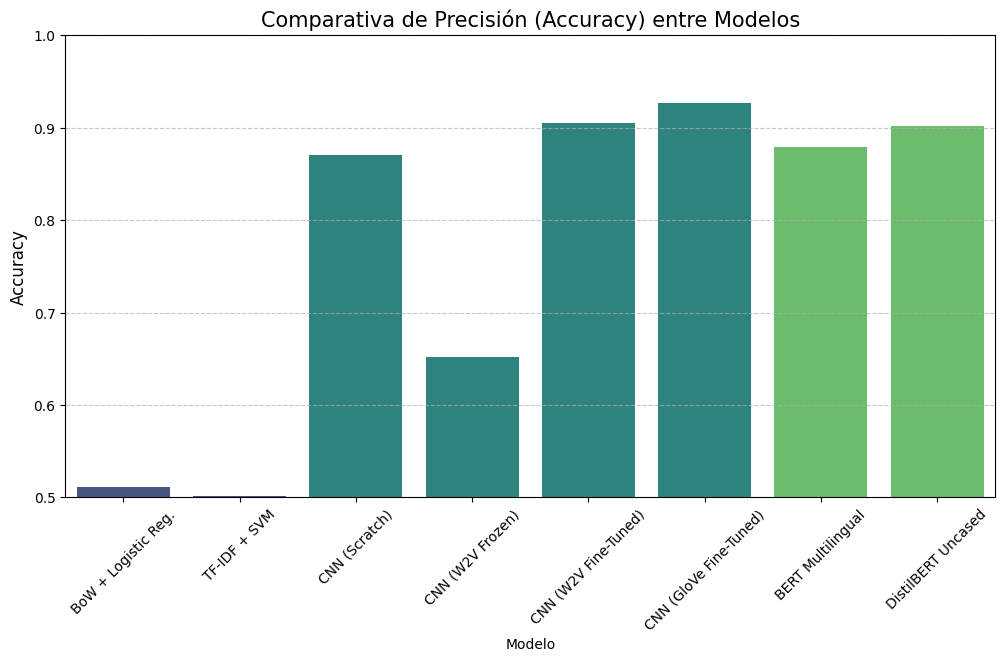

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

resultados = {
    'Modelo': [
        'BoW + Logistic Reg.', 
        'TF-IDF + SVM', 
        'CNN (Scratch)', 
        'CNN (W2V Frozen)', 
        'CNN (W2V Fine-Tuned)', 
        'CNN (GloVe Fine-Tuned)',
        'BERT Multilingual',
        'DistilBERT Uncased'
    ],
    'Accuracy': [
        0.5117,  # BoW + Logistic Regression
        0.5021,  # TF-IDF + SVM
        0.8708,  # CNN Scratch
        0.6515,  # CNN Frozen 
        0.9057,  # CNN W2V Fine-Tuned
        0.9269,  # CNN GloVe 
        0.8792,  # BERT Multilingual
        0.9025   # DistilBERT Uncased
    ],
    'Tipo': ['Clásico', 'Clásico', 'Deep Learning', 'Deep Learning', 'Deep Learning', 'Deep Learning', 'Contextual', 'Contextual']
}

df_resultados = pd.DataFrame(resultados)
display(df_resultados.sort_values(by='Accuracy', ascending=False))

plt.figure(figsize=(12, 6))
sns.barplot(data=df_resultados, x='Modelo', y='Accuracy', hue='Tipo', palette='viridis', legend=False)
plt.ylim(0.5, 1.0) 
plt.title('Comparativa de Precisión (Accuracy) entre Modelos', fontsize=15)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Accuracy: 92.37%
              precision    recall  f1-score   support

     Neutral       0.90      0.94      0.92       434
      Tóxico       0.95      0.91      0.93       510

    accuracy                           0.92       944
   macro avg       0.92      0.92      0.92       944
weighted avg       0.92      0.92      0.92       944



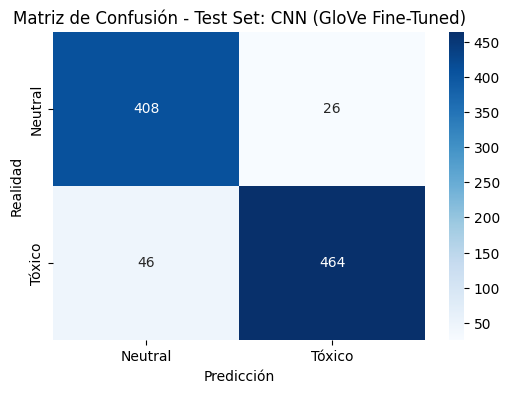

In [18]:
# Análisis del mejor modelo - CNN (GloVe Fine-Tuned)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def evaluar_modelo_final(model, test_loader):

    model.eval()  
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): 
        for X_batch, y_batch in test_loader:
            
            # La salida del modelo ya es un tensor de probabilidad gracias al Wrapper
            outputs = model(X_batch)
            
            # Convertir probabilidad a clase (0 o 1)
            predicted = (outputs > 0.5).float()
            
            # Guardar resultados (móviles de vuelta a la CPU para numpy/sklearn)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # 3. Calcular métricas con Scikit-Learn
    acc = accuracy_score(all_labels, all_preds)
    
    print(f"Accuracy: {acc:.2%}")
    print(classification_report(all_labels, all_preds, target_names=['Neutral', 'Tóxico']))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Tóxico'], yticklabels=['Neutral', 'Tóxico'])
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.title('Matriz de Confusión - Test Set: CNN (GloVe Fine-Tuned)')
    plt.show()
    
    return acc

acc_distilbert = evaluar_modelo_final(model_glove_finetuned, test_loader)

## 9. Conclusiones

Tras evaluar las diferentes estrategias diferentes, hemos llegado a las siguientes conclusiones.

### 1. El Ganador: Transfer Learning (CNN + GloVe)
El mejor rendimiento se obtuvo con **CNN + GloVe Fine-Tuned**, alcanzando una precisión del **92.69%**.
Esto demuestra el poder del **Transfer Learning**. Al utilizar embeddings pre-entrenados en millones de textos globales y ajustarlos a nuestro problema, el modelo logró captar matices que el entrenamiento solo con nuestro dataset pequeño no permitía.

### 2. Los Modelos Clásicos
Los modelos base (TF-IDF + SVM y Regresión Logística) mostraron un rendimiento muy pobre, con precisiones cercanas a 0.50 (50.0%), que es practicamente adivinar al azar, esto indica que los modelos clásicos no lograron generalizar.

### 3. La Importancia Vital del Fine-Tuning
El hallazgo más crítico del experimento está en la comparación de Word2Vec:
* **W2V Frozen (65.15%):** Rendimiento muy pobre. Los embeddings estáticos no se adaptaron bien a la red convolucional.
* **W2V Fine-Tuned (90.57%):** Al permitir que la red ajustara los pesos de los embeddings, el rendimiento se disparó más de un **25%**.
* **Conclusión:** Para tareas específicas de NLP, **es obligatorio descongelar (unfreeze)** los embeddings para permitir que el modelo adapte el significado de las palabras al contexto específico.

### 4. La Sensibilidad Extrema de los Modelos Contextuales
La estrategia final, basada en Fine-Tuning de Transformadores (BERT/DistilBERT), no logró el liderazgo, a pesar de su complejidad y coste computacional. Al contar con un conjunto de datos limitado y habiendo una clara componente léxica en la clasificación, BERT no fue capaz de aportar una ventaja significativa.

### Resumen Final
Hemos logrado pasar de una línea base del **50%** (Regresión Logística) a un modelo de Deep Learning robusto del **92.69%** (CNN+GloVe), demostrando que la combinación de redes neuronales con conocimiento pre-entrenado es la estrategia óptima para resolver este problema.